# Spatial Dynamics of Chinese Restaurant Ratings: Asian Density and

Location Patterns in Maryland

DSAN 6750 / PPOL 6805: GIS for Spatial Data Science

Chen, Yihan; Deng, Liuting; Wang, Jiankun; Wang, Yongbo (Georgetown University)

## 1. Introduction

### 1.1 Background

Speaking of authentic Chinese food, places like the Bay Area in California and Flushing in New York City often come to mind. These regions, known for their vibrant Asian communities, boast many Chinese restaurants that provide authentic flavors. In contrast, the DMV area (D.C., Maryland, and Virginia) often falls short in this regard, with Chinese cuisine that feels less connected to its roots. What are the reasons behind this? One possibility lies in demographics—fewer Asian residents across the region may contribute to a diminished demand for authenticity. However, within the DMV, Maryland still stands out. It’s widely regarded as having better Chinese food compared to D.C. or Virginia, likely because of its relatively larger Asian population.

From personal observations and countless taste tests (sadly), we identify one pattern: the farther one ventures into areas with higher concentrations of Asian residents, the more likely they are to stumble upon a Chinese restaurant that serves dishes closer to the original flavors. This could be attributed to clusters of Chinese communities, which create a stronger demand for authentic food, coupled with cheaper rent in suburban areas, allowing restaurants to focus on quality.

We are curious to explore whether this anecdotal pattern holds up to statistics. Is there a measurable relationship between the density of Asian residents and Chinese restaurant ratings? Moreover, are there spatial clusters of high-rated restaurants, and does the presence of these clusters create spillover effects, where one good restaurant inspires the success of others nearby?

These questions have implications far beyond satisfying us, crazy foodies, to find a better site in the DMV. For potential business investors or restaurant owners, understanding these relationships could guide strategic decisions about where to open new locations.

------------------------------------------------------------------------

### 1.2 Location Model (Economics)

The importance of locations in economics is demonstrated by two prominent models: **Hotelling’s Location Model** and **Salop’s Circle Model**, which explore the relationship between geography, consumer behavior, and firm strategies.

#### 1.2.1 Hotelling’s Location Model

> “In 1929, Hotelling developed a location model that demonstrates the relationship between location and pricing behavior of firms. He represented this notion through a line of fixed length. Assuming all consumers are identical (except for location) and consumers are evenly dispersed along the line, both the firms and consumers respond to changes in demand and the economic environment. Firms do not exercise variations in product characteristics; firms compete and price their products in only one dimension, geographic location. Therefore, traditional usage of this model should be used for consumers who perceive products to be perfect substitutes or as a foundation for modern location models.”

For more details, see [this website](https://en.wikipedia.org/wiki/Location_model_(economics)#Hotelling%27s_Location_Model).

Hotelling’s model predicts that businesses should cluster in the middle of a market to maximize their customer base. For example, in a linear spatial market, if one restaurant exists in a neighborhood, a competing restaurant might choose to locate directly next to it. This way, the market splits into halves, with each business capturing customers on its side.

This model assumes that businesses compete solely on geographic location, with products being perfect substitutes. The idea parallels the **Median Voter Theorem**, where competitors slightly undercut each other until they meet equilibrium.

#### 1.2.2 Salop’s Circle Model

> “Similar to the previous spatial representations, the circle model examines consumer preference with regards to geographic location. However, Salop introduces two significant factors: 1) firms are located around a circle with no endpoints, and 2) it allows the consumer to choose a second, heterogeneous good.”

For more details, see [this website](https://en.wikipedia.org/wiki/Location_model_(economics)#Salop's_Circle_Model).

The Salop model takes an opposing perspective. It proposes that businesses should avoid clustering and instead space themselves to maximize accessibility for the greatest number of consumers. It ensures geographic diversity and minimal overlap in customer bases.

------------------------------------------------------------------------

### 1.3 Hypotheses

-   **Hypothesis 1**: Higher Asian population density is positively associated with Chinese restaurant ratings.
-   **Hypothesis 2**: High-rated Chinese restaurants exhibit spatial clustering.
-   **Hypothesis 3**: Spatial clustering of high-rated restaurants creates positive spillover effects on nearby establishments.

------------------------------------------------------------------------

## 2. Data and Methods

### 2.1 Data Source

The data for this study is sourced from two primary platforms:

-   **Point of Interest (POI) Data**:
    -   Chinese restaurant data in Maryland was collected using the Google Maps enrichment service provided by **Outscraper**.
    -   This dataset includes restaurant location details and ratings, with information updated for 2024.
-   **Demographic and Socioeconomic Data**:
    -   Data such as population and income were obtained from the U.S. Census Bureau’s **American Community Survey (ACS)** 5-Year Estimates.
    -   The ACS data reflects information collected in 2022, the most recent survey year available.

------------------------------------------------------------------------

### 2.2 Data Cleaning

The following steps were taken to ensure alignment with the 2022 demographic data:

-   **Filtering by Year**:

    -   Restaurants that opened after 2022 were excluded to align with the available demographic data.

-   **Creating Asian Density Variable**:

    -   Using the merged data, a new variable, **Asian Density**, was created, calculated as:

$$
\text{Asian Density} = \frac{\text{Asian Population}}{\text{Total Population}}
$$

-   **Geographic Focus: Commuting Area**:

    -   A map of Chinese restaurant locations revealed a concentration in the **Washington, D.C.**, and **Baltimore metropolitan commuting areas**.
    -   Based on this observation, the dataset was refined to include only restaurants in these areas. The regions were defined using the **Office of Management and Budget (OMB)** standards for metropolitan and micropolitan areas.

------------------------------------------------------------------------

## 3. Exploratory Data Analysis

After cleaning, the main dataset was then converted into a spatial data frame using longitude and latitude coordinates with the WGS 84 projection (CRS 4326). Maryland block group boundaries for 2022 were retrieved. Both datasets were reprojected to a consistent CRS to ensure spatial compatibility for our analysis.

### 3.1 Descriptive Statistics

In [ ]:
#| label: imports
#| code-fold: true
#| message: false
#| warning: false
#| echo: false
options(warn = -1)
suppressMessages({
  library(sp)
  library(sf)
  library(spdep)
  library(lmtest)
  library(sandwich)
  library(ggplot2)
  library(spatialreg)
  library(tmap)
  library(tigris)
  library(dplyr)
  library(tidyverse)
  library(leaflet)
  library(units)
  library(readxl)
  library(mapview)
})

In [ ]:
#| label: load-eda
#| code-fold: true
#| message: false
#| warning: false
#| echo: false
data <- read.csv("restaurant.csv")
data <- na.omit(data)

data_sf <- st_as_sf(data, coords = c("longitude", "latitude"), crs = 4326)
md_block_groups <- block_groups(state = "MD", year = 2022, progress_bar = FALSE)
md_block_groups <- st_transform(md_block_groups, crs = st_crs(data_sf))
data_sf <- st_transform(data_sf, crs = st_crs(md_block_groups))

#### 3.1.1 Restaurant and Rating

A histogram was generated to visualize the distribution of restaurant ratings in Maryland.

Indeed, Maryland Chinese restaurants are generally well-rated. Most Chinese restaurants have ratings concentrated between 3.5 and 4.5, with a peak around 4.0. Ratings below 3.0 and above 4.5 are rare, following a normal distribution.

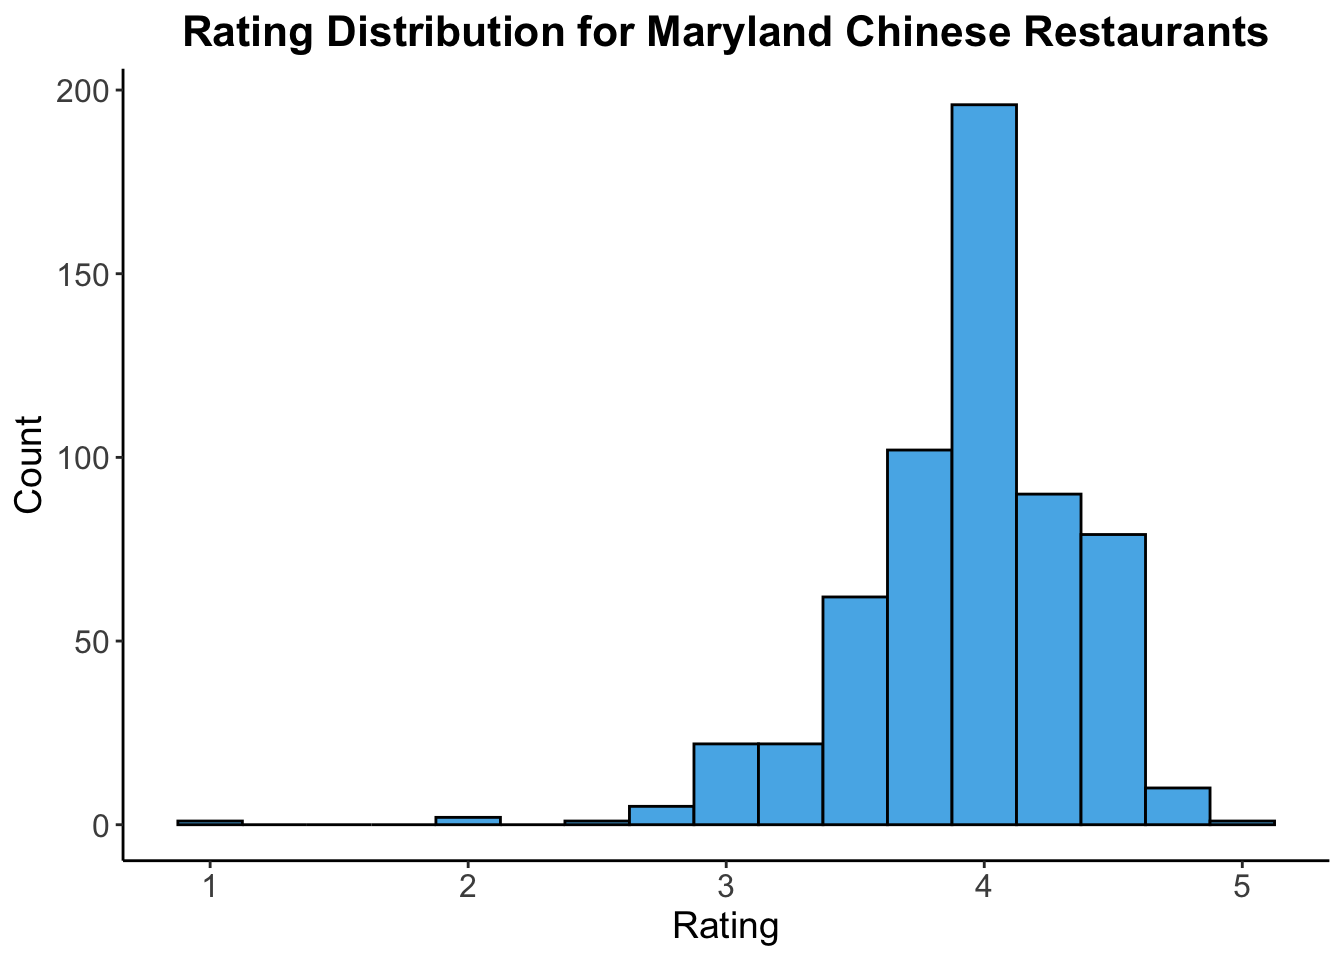

In [ ]:
#| label: plot restaurant
#| code-fold: true
#| message: false
#| warning: false
ggplot(data, aes(x = rating)) +
  geom_histogram(
    binwidth = 0.25, 
    fill = "#56B4E9", 
    color = "black"  
  ) +
  theme_classic() + 
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),  
    axis.title = element_text(size = 14),  
    axis.text = element_text(size = 12) 
  ) +
  labs(
    title = "Rating Distribution for Maryland Chinese Restaurants",
    x = "Rating",
    y = "Count"
  )

The map overlays restaurant data on Maryland block group boundaries, with restaurants color-coded by their ratings.

It shows a clustering of restaurants in urbanized and suburban areas, particularly around Baltimore and the D.C. metropolitan area. This finding leads us to narrow down our restaurant dataset to a commuting area in the later section. Ratings are distributed across locations, with no clear trend of higher ratings clustering in specific regions. Review counts vary significantly, with some restaurants attracting more reviews than others.

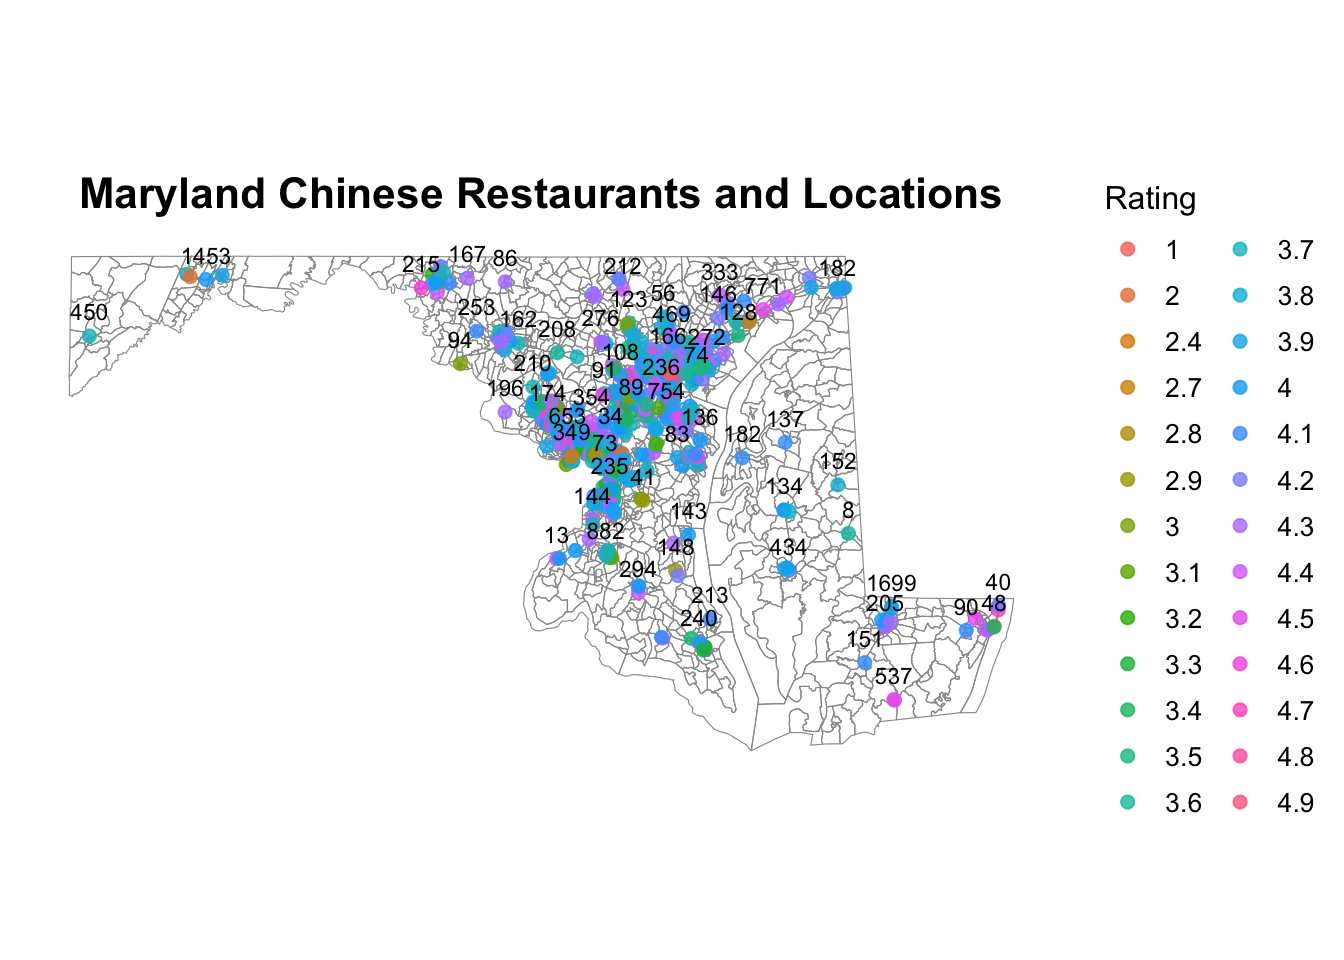

In [ ]:
#| label: Maryland Chinese Restaurants and Locations
#| code-fold: true
#| message: false
#| warning: false
data_with_coords <- data_sf %>%
  mutate(
    x = st_coordinates(.)[, 1], 
    y = st_coordinates(.)[, 2]
  )

ggplot() +
  geom_sf(data = md_block_groups, color = "gray60", fill = NA, size = 0.4) +
  geom_sf(data = data_sf, aes(color = as.factor(rating)), size = 2, alpha = 0.8) +
  geom_text(
    data = data_with_coords,
    aes(x = x, y = y, label = reviews),
    size = 3, vjust = -1, check_overlap = TRUE, color = "black"
  ) +
  labs(
    title = "Maryland Chinese Restaurants and Locations",
    color = "Rating"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"), 
    legend.title = element_text(size = 12),  
    legend.text = element_text(size = 10),   
    axis.text = element_blank(), 
    axis.title = element_blank(), 
    axis.ticks = element_blank(), 
    panel.grid = element_blank(),
    panel.background = element_blank() 
  )

#### 3.1.2 Asian Density

This graph displays the distribution of Asian density in Maryland. The distribution is notably right-skewed, in the range from 0 to 0.5.

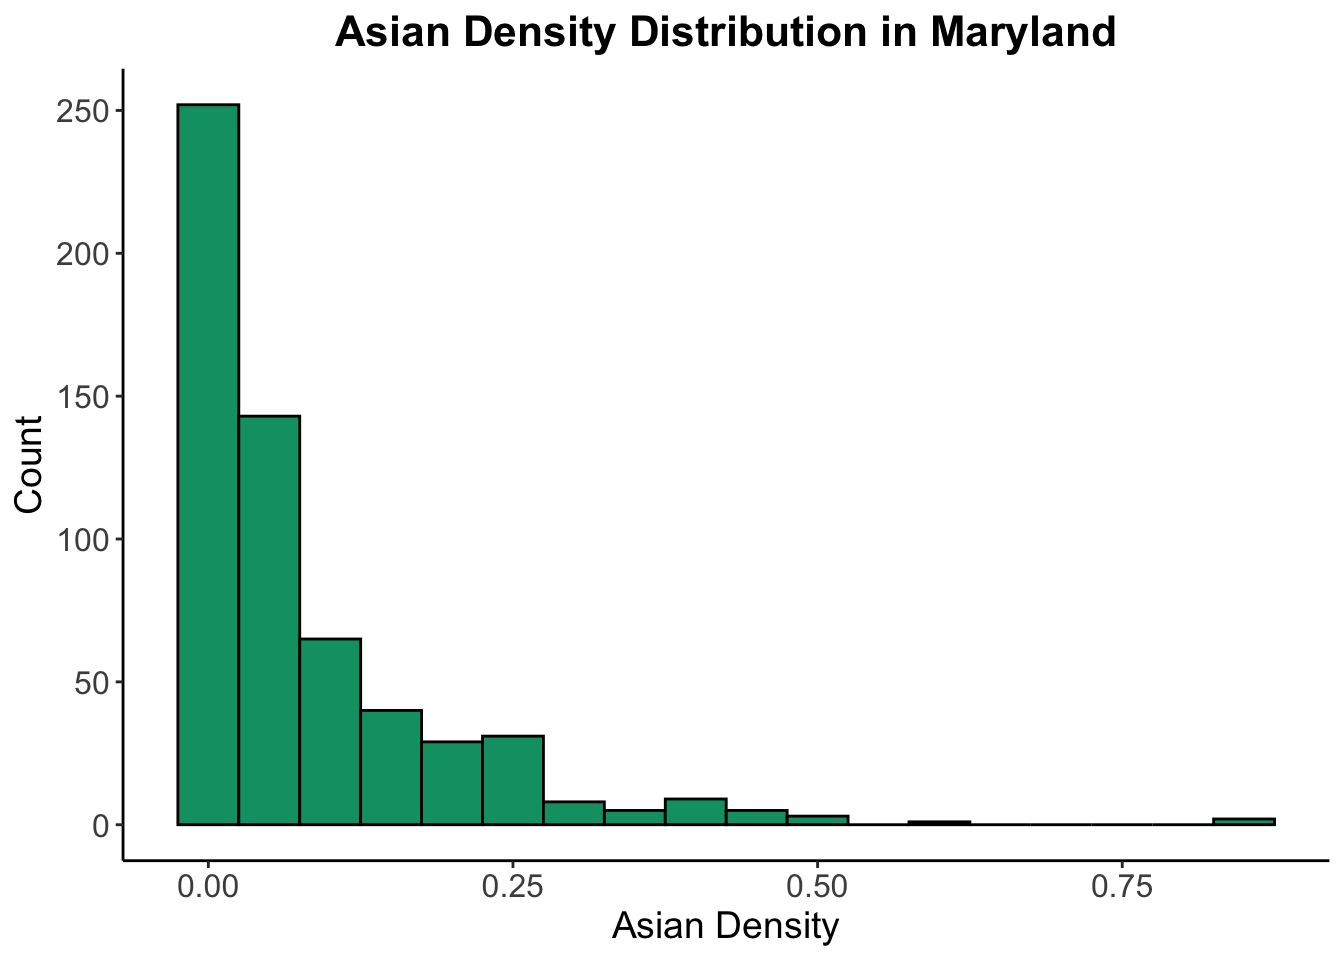

In [ ]:
#| label: Asian Density Distribution in Maryland
#| code-fold: true
#| message: false
#| warning: false
ggplot(data, aes(x = AsianDensity)) +
  geom_histogram(
    binwidth = 0.05, 
    fill = "#009E73", 
    color = "black" 
  ) +
  theme_classic() +  
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),  
    axis.title = element_text(size = 14), 
    axis.text = element_text(size = 12) 
  ) +
  labs(
    title = "Asian Density Distribution in Maryland",
    x = "Asian Density",
    y = "Count"
  )

This presents a geographic visualization of average Asian density by block group. Following the pattern revealed in the previous graph, we used the scale from 0 to 0.5. The map shows that areas with higher Asian density tend to be located in commuting zones, suggesting a trend where the populations are concentrated in metropolitan areas.

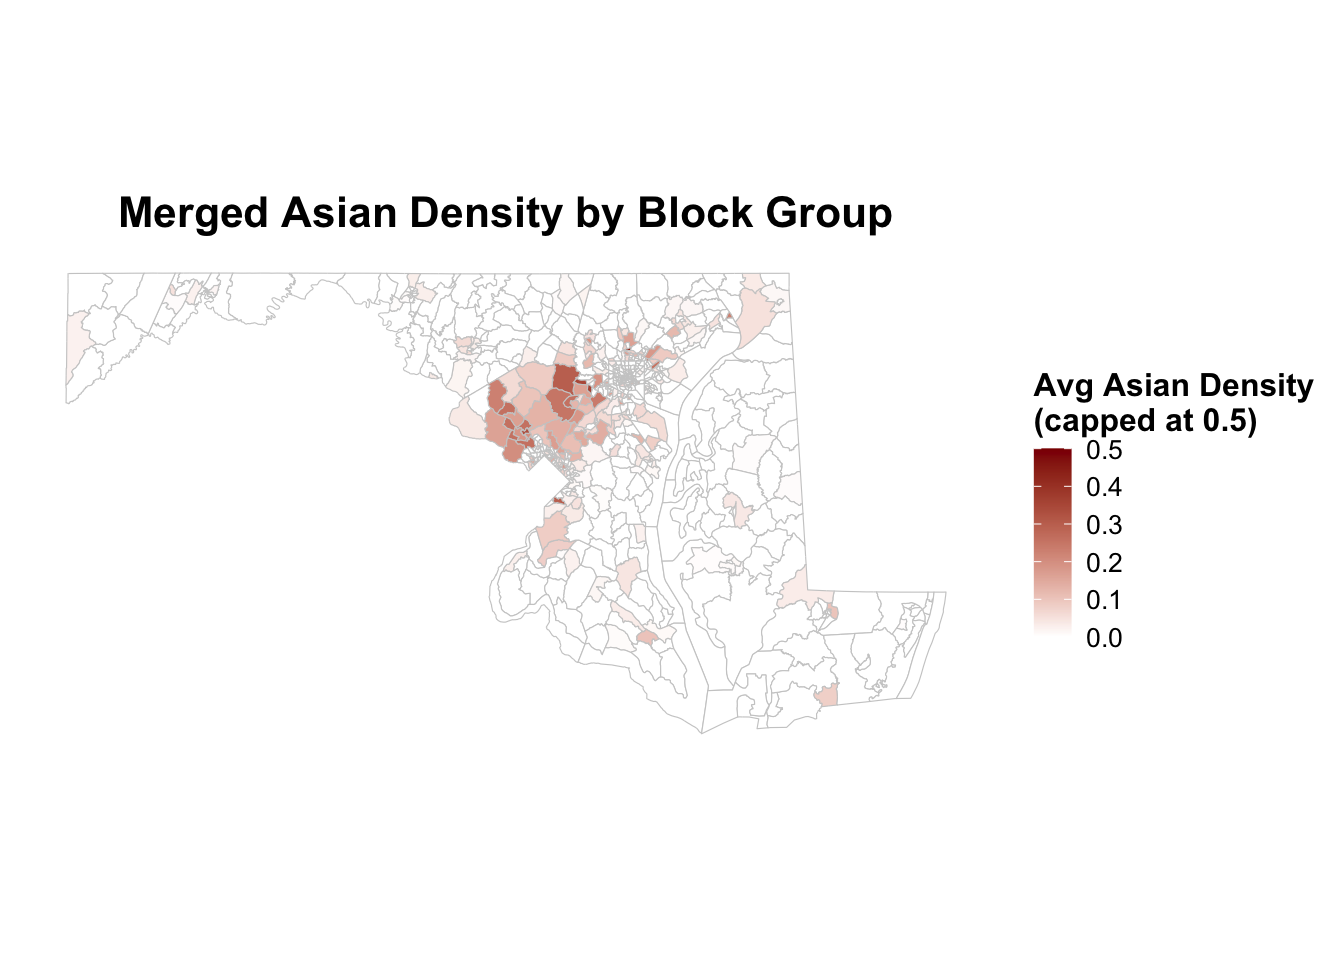

In [ ]:
#| label: Merged Asian Density by Block Group
#| code-fold: true
#| message: false
#| warning: false
asian_density_summary <- data_sf %>%
  st_drop_geometry() %>%
  group_by(GEOID) %>%
  summarize(AsianDensity = mean(AsianDensity, na.rm = TRUE)) %>%
  ungroup() %>%
  mutate(
    GEOID = as.character(GEOID),
    GEOID = str_pad(GEOID, width = 11, side = "left", pad = "0")
  )

md_block_groups_merged <- md_block_groups %>%
  left_join(asian_density_summary, by = "GEOID") %>%
  mutate(GEOID_prefix = substr(GEOID, 1, 9)) %>%
  group_by(GEOID_prefix) %>%
  summarize(
    geometry = st_union(geometry),  
    AsianDensity = mean(AsianDensity, na.rm = TRUE)
  )

ggplot(data = md_block_groups_merged) +
  geom_sf(aes(fill = AsianDensity), color = "gray80", size = 0.2) + 
  scale_fill_gradient(
    low = "white",
    high = "darkred",
    na.value = "white",
    limits = c(0, 0.5)
  ) +
  labs(
    fill = "Avg Asian Density\n(capped at 0.5)",
    title = "Merged Asian Density by Block Group"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),  
    legend.title = element_text(size = 12, face = "bold"), 
    legend.text = element_text(size = 10), 
    legend.key.size = unit(0.5, "cm"),  
    panel.grid = element_blank(), 
    panel.background = element_blank(), 
    axis.text = element_blank(), 
    axis.title = element_blank(), 
    axis.ticks = element_blank()  
  )

------------------------------------------------------------------------

### 3.2 Commuting Area

#### 3.2.1 Restaurant Locations in Commuting Area

This graph shows the restaurant locations within metropolitan areas, with each blue dot representing a restaurant. The high concentration of restaurants in the commuting area results from narrowing down the original dataset by using the OMB standard to filter the restaurants in metropolitan areas. This high concentration is advantageous for regression analysis in the later part of the study.

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
restaurant_data <- readxl::read_excel("filtered.xlsx")
restaurant_data <- na.omit(restaurant_data)

restaurant_sf <- st_as_sf(restaurant_data, coords = c("longitude", "latitude"), crs = 4326)

md_counties <- counties(state = "MD", year = 2022, class = "sf", progress_bar = FALSE)

counties_of_interest <- c("Montgomery", "Prince George's", "Calvert", "Charles", "St. Mary's",
                          "Baltimore city", "Anne Arundel", "Baltimore", "Carroll", "Harford",
                          "Howard", "Queen Anne's")

selected_counties <- md_counties[md_counties$NAME %in% counties_of_interest, ]

restaurant_sf <- st_transform(restaurant_sf, crs = st_crs(selected_counties))
selected_counties <- st_transform(selected_counties, crs = st_crs(restaurant_sf))

restaurant_sf_cropped <- st_intersection(restaurant_sf, st_union(selected_counties))

maryland_block_groups <- block_groups(state = "MD", year = 2022, progress_bar = FALSE)

asian_density_summary <- restaurant_data %>%
  group_by(GEOID) %>%
  summarize(AsianDensity = mean(`AsianPopulation` / `TotalPopulation`, na.rm = TRUE))

maryland_block_groups <- maryland_block_groups %>%
  mutate(GEOID = as.character(GEOID)) %>%
  left_join(asian_density_summary, by = "GEOID")

maryland_block_groups <- st_transform(maryland_block_groups, crs = st_crs(selected_counties))
maryland_block_groups_cropped <- st_intersection(maryland_block_groups, st_union(selected_counties))

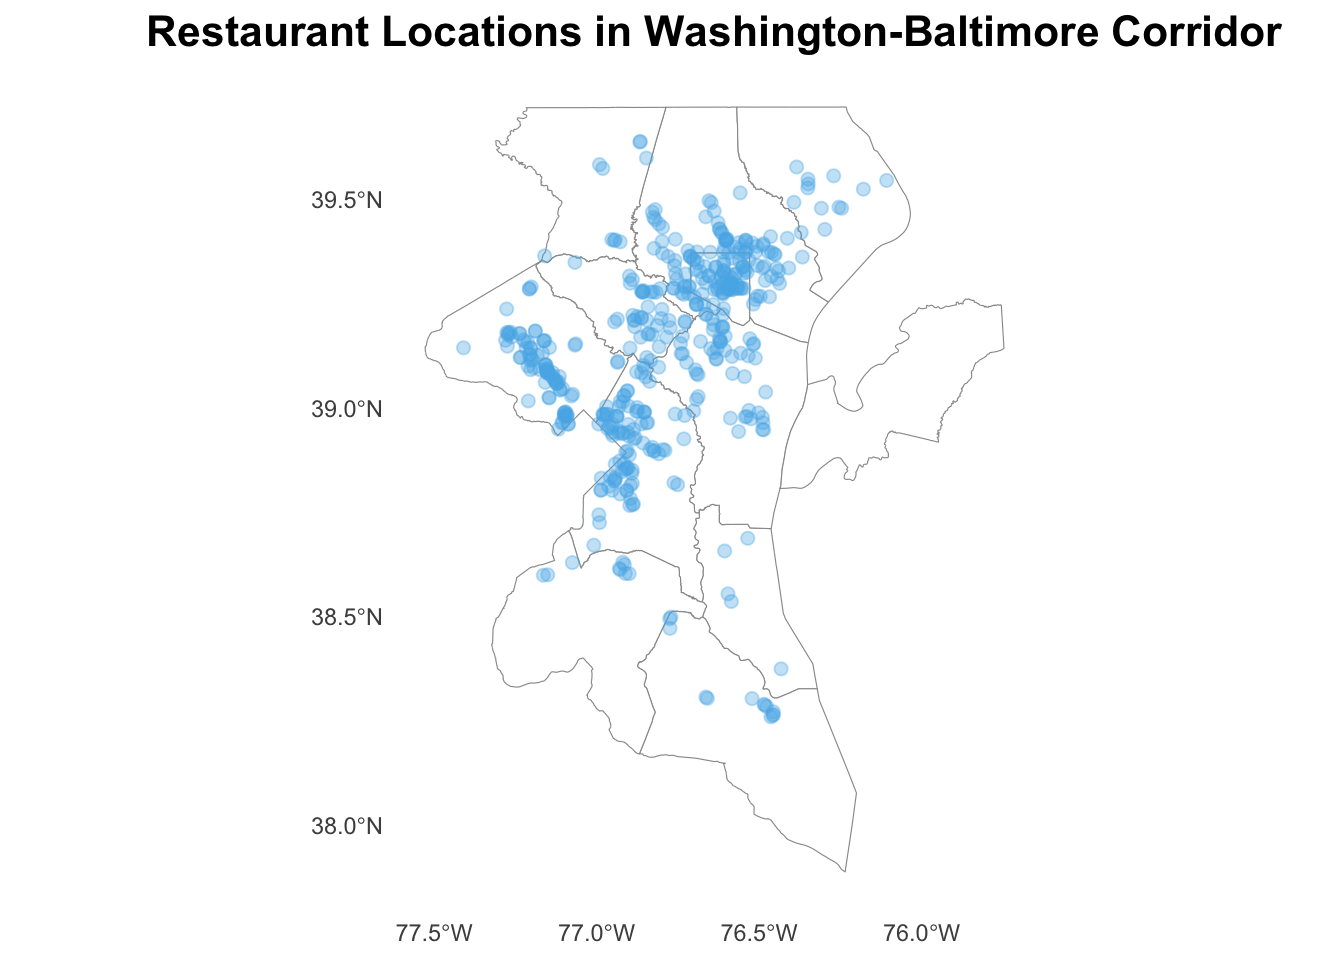

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
ggplot() +
  geom_sf(data = selected_counties, fill = "white", color = "gray60", size = 0.3) +
  geom_sf(data = restaurant_sf_cropped, color = "#56B4E9", size = 2, alpha = 0.35) +
  labs(
    title = "Restaurant Locations in Washington-Baltimore Corridor",
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"), 
    plot.caption = element_text(size = 10, hjust = 1, face = "italic"), 
    panel.grid = element_blank(), 
    panel.background = element_blank(),  
    legend.position = "none",  
  )

We also present it with the mapview package.

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
mapview(selected_counties, color = "gray", alpha = 0.3) + 
  mapview(
    restaurant_sf_cropped,
    zcol = "rating",                     
    col.regions = colorRampPalette(c("#56B4E9", "#E69F00", "#D55E00"))(100),  
    cex = 4,                             
    alpha = 0.7                          
  )

#### 3.2.2 Asian Density in Commuting Area

This displays Asian density by block group based on a narrowed-down dataset. It clearly shows that higher Asian density is concentrated in the Washington, D.C., and Baltimore commuting areas.

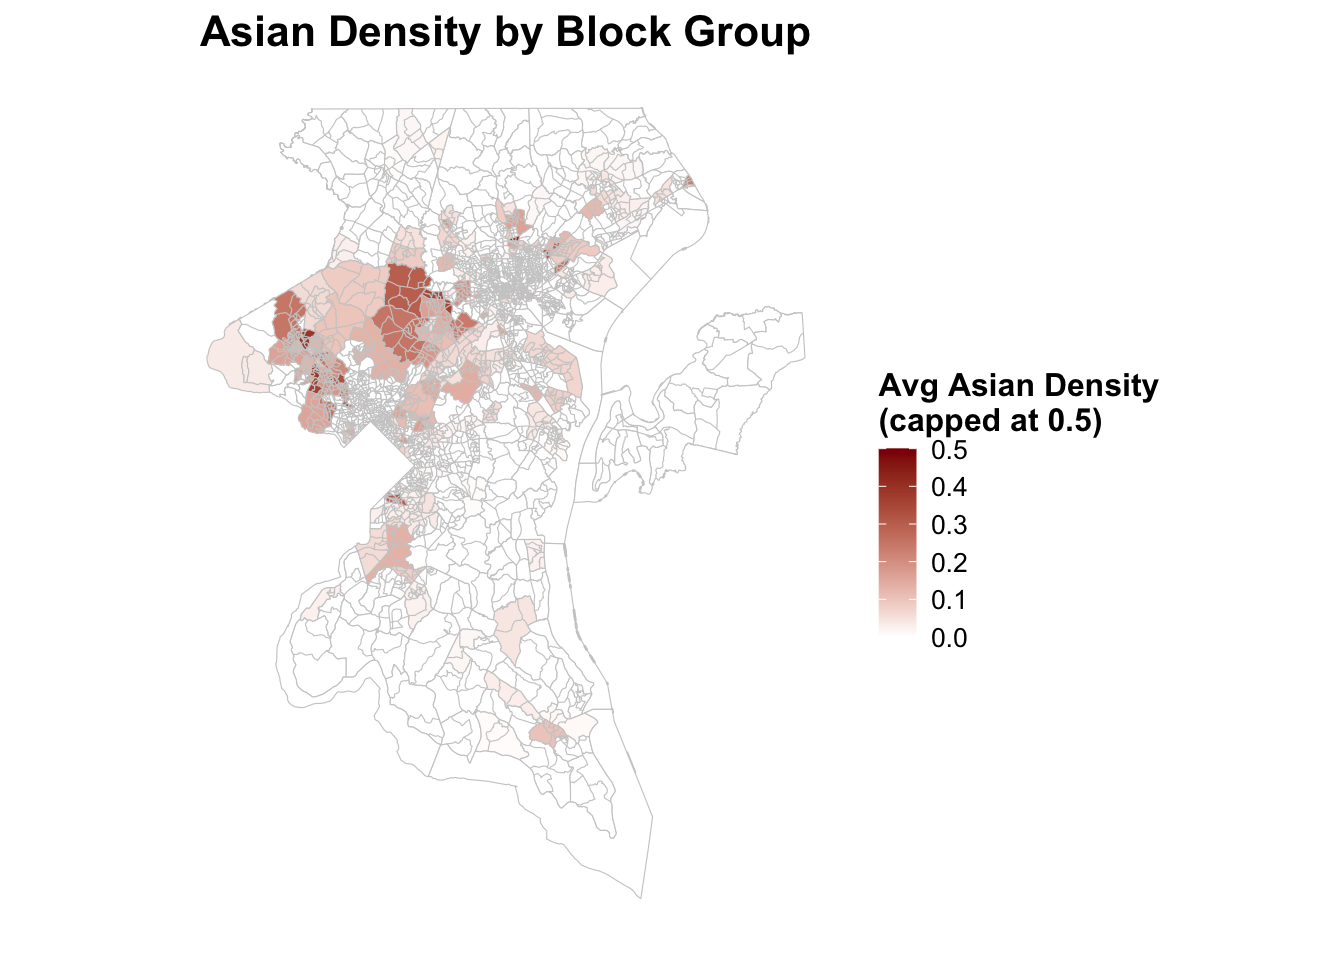

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
maryland_block_groups_merged <- maryland_block_groups_cropped %>%
  mutate(GEOID_prefix = substr(GEOID, 1, 10)) %>% 
  group_by(GEOID_prefix) %>%
  summarize(
    geometry = st_combine(geometry),           
    AsianDensity = mean(AsianDensity, na.rm = TRUE)  
  )

asian_density_map <- ggplot(data = maryland_block_groups_merged) +
  geom_sf(aes(fill = AsianDensity), color = "gray80", size = 0.2) +  
  scale_fill_gradient(
    low = "white",
    high = "darkred",
    na.value = "white",
    limits = c(0, 0.5)
  ) +
  labs(
    fill = "Avg Asian Density\n(capped at 0.5)",
    title = "Asian Density by Block Group"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),  
    legend.title = element_text(size = 12, face = "bold"),  
    legend.text = element_text(size = 10), 
    legend.key.size = unit(0.5, "cm"), 
    panel.grid = element_blank(),  
    panel.background = element_blank(), 
    axis.text = element_blank(),  
    axis.title = element_blank(),  
    axis.ticks = element_blank()   
  )

print(asian_density_map)

------------------------------------------------------------------------

## 4. Spacial Analysis

Before investigating the relevance of spatial effects in our hypothesis, let’s try a non-spatial regression model: it may simply be that the spatial autocorrelation in rating of restaurants is entirely explained by the Asian density in Maryland.

### 4.1 Regression Analysis (OLS)

To investigate whether the ratings of Chinese restaurants in Maryland are influenced by local demographic and socioeconomic factors, we fit a “standard” OLS model to estimate the variables of our interests:

$$
\text{Rating}_i = \beta_0 + \beta_1 \cdot \text{AsianDensity}_i + \beta_2 \cdot \text{MedianHouseIncome}_i + \beta_3 \cdot \text{PublicTransport}_i + \epsilon_i
$$

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
asian_density_summary <- asian_density_summary %>%
  mutate(GEOID = as.character(GEOID))

restaurant_data <- restaurant_data %>%
  mutate(GEOID = as.character(GEOID)) %>%
  left_join(asian_density_summary, by = "GEOID")

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
ols_model <- lm(rating ~ AsianDensity + MedianHouseholdIncome + PublicTransportationCommuters , 
                data = restaurant_data)
summary(ols_model)


Call:
lm(formula = rating ~ AsianDensity + MedianHouseholdIncome + 
    PublicTransportationCommuters, data = restaurant_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.85964 -0.21188  0.04846  0.28832  0.91235 

Coefficients:
                                Estimate Std. Error t value Pr(>|t|)    
(Intercept)                    3.875e+00  5.310e-02  72.980   <2e-16 ***
AsianDensity                   3.974e-01  1.650e-01   2.408   0.0164 *  
MedianHouseholdIncome         -3.192e-04  2.379e-04  -1.342   0.1803    
PublicTransportationCommuters  3.363e-07  4.635e-07   0.726   0.4684    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4269 on 515 degrees of freedom
Multiple R-squared:  0.01665,   Adjusted R-squared:  0.01092 
F-statistic: 2.906 on 3 and 515 DF,  p-value: 0.03425

Higher Asian population density positively influences restaurant ratings (p = 0.0164). But median household income and the number of public transport commuters in the OLS model are insignificant.

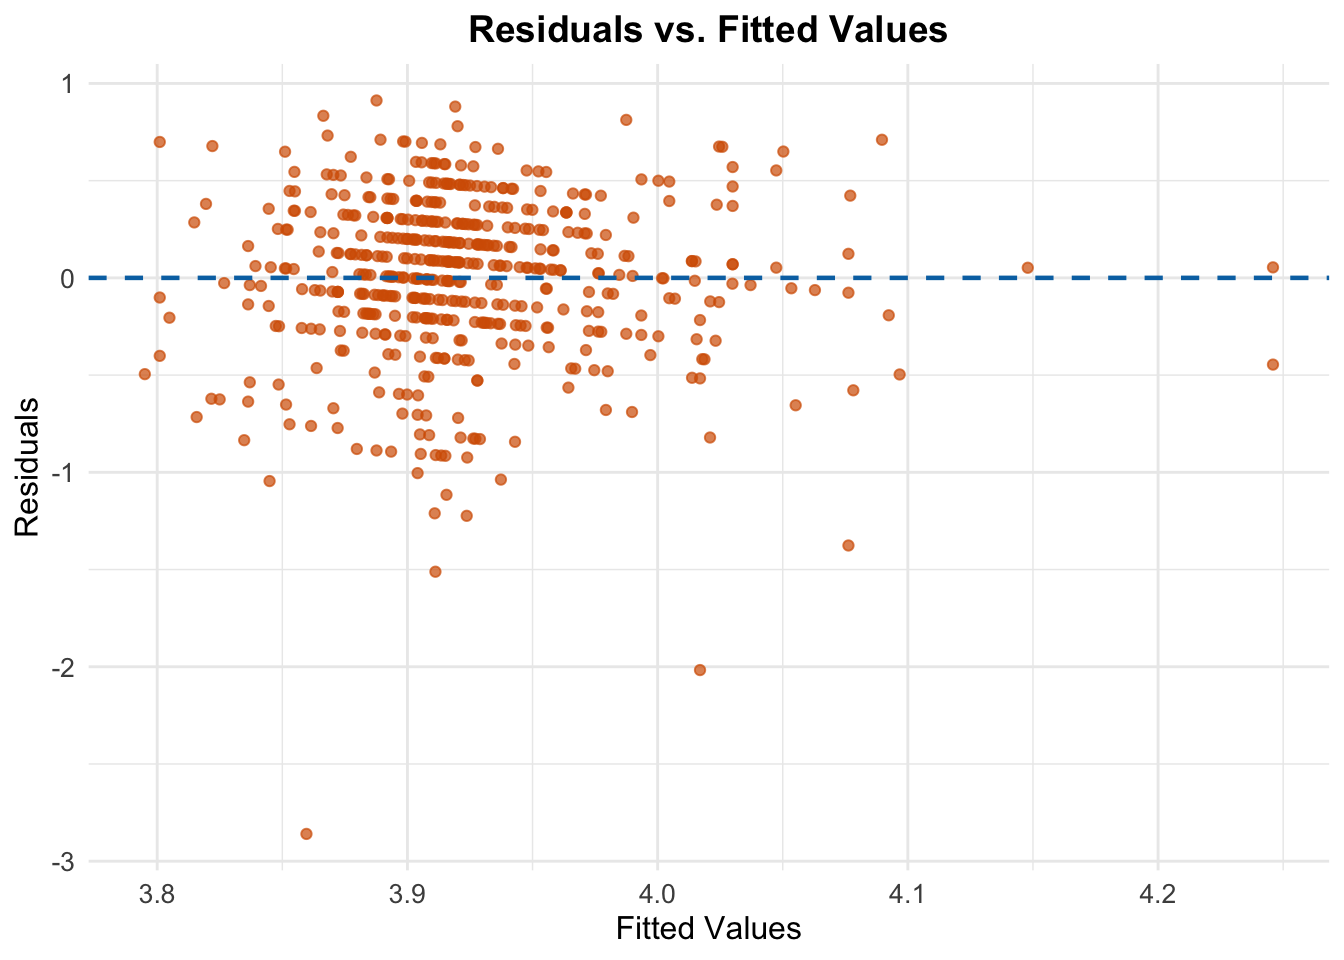

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
residuals <- resid(ols_model)
fitted_values <- fitted(ols_model)


ggplot(data = data.frame(fitted_values, residuals), aes(x = fitted_values, y = residuals)) +
  geom_point(color = "#D55E00", alpha = 0.7) + 
  geom_hline(yintercept = 0, color = "#0072B2", linetype = "dashed", size = 0.8) +
  labs(
    title = "Residuals vs. Fitted Values", 
    x = "Fitted Values", 
    y = "Residuals"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"), 
    axis.title = element_text(size = 12),  
    axis.text = element_text(size = 10) 
  )

We create a scatter plot of residuals vs. fitted values to assess the OLS model’s fit and residual distribution. The residuals, derived from the model, are evenly distributed around a zero line with no clear patterns, indicating a good fit. But we are still curious if residuals from OLS estimation exhibit a relationship, due to spatial autocorrelation with tools.

------------------------------------------------------------------------

### 4.2 Spacial Residual (Moran’s I)

Moran’s 𝐼 is used to test if our error terms are independent of the spatial distribution.

To define neighbors for Moran’s 𝐼, a spatial weights matrix is used to represent relationships between restaurants. Neighbors are defined using 5 nearest neighbors, linking each restaurant to its five closest neighbors by geographical coordinates.

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
restaurant_sf <- st_as_sf(restaurant_data, coords = c("longitude", "latitude"), crs = 4326)
coords <- st_coordinates(restaurant_sf)
k_nb <- knn2nb(knearneigh(coords, k =5))
listw_k <- nb2listw(k_nb, style = "W")

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
moran_rating <- moran.test(restaurant_sf$rating, listw_k)
print(moran_rating)


    Moran I test under randomisation

data:  restaurant_sf$rating  
weights: listw_k    

Moran I statistic standard deviate = 2.4501, p-value = 0.007141
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.0605012488     -0.0019305019      0.0006492981 


    Moran I test under randomisation

data:  residuals_ols  
weights: listw_k    

Moran I statistic standard deviate = 1.3986, p-value = 0.08097
alternative hypothesis: greater
sample estimates:
Moran I statistic       Expectation          Variance 
     0.0337077068     -0.0019305019      0.0006493258 

For restaurant ratings, Moran’s 𝐼 = 0.0605 (p = 0.0071) indicates significant positive spatial autocorrelation, suggesting clustering of high and low ratings. However, for regression residuals, Moran’s 𝐼 = 0.0338 (p = 0.0809) shows weaker spatial autocorrelation.

`geom_smooth()` using formula = 'y ~ x'

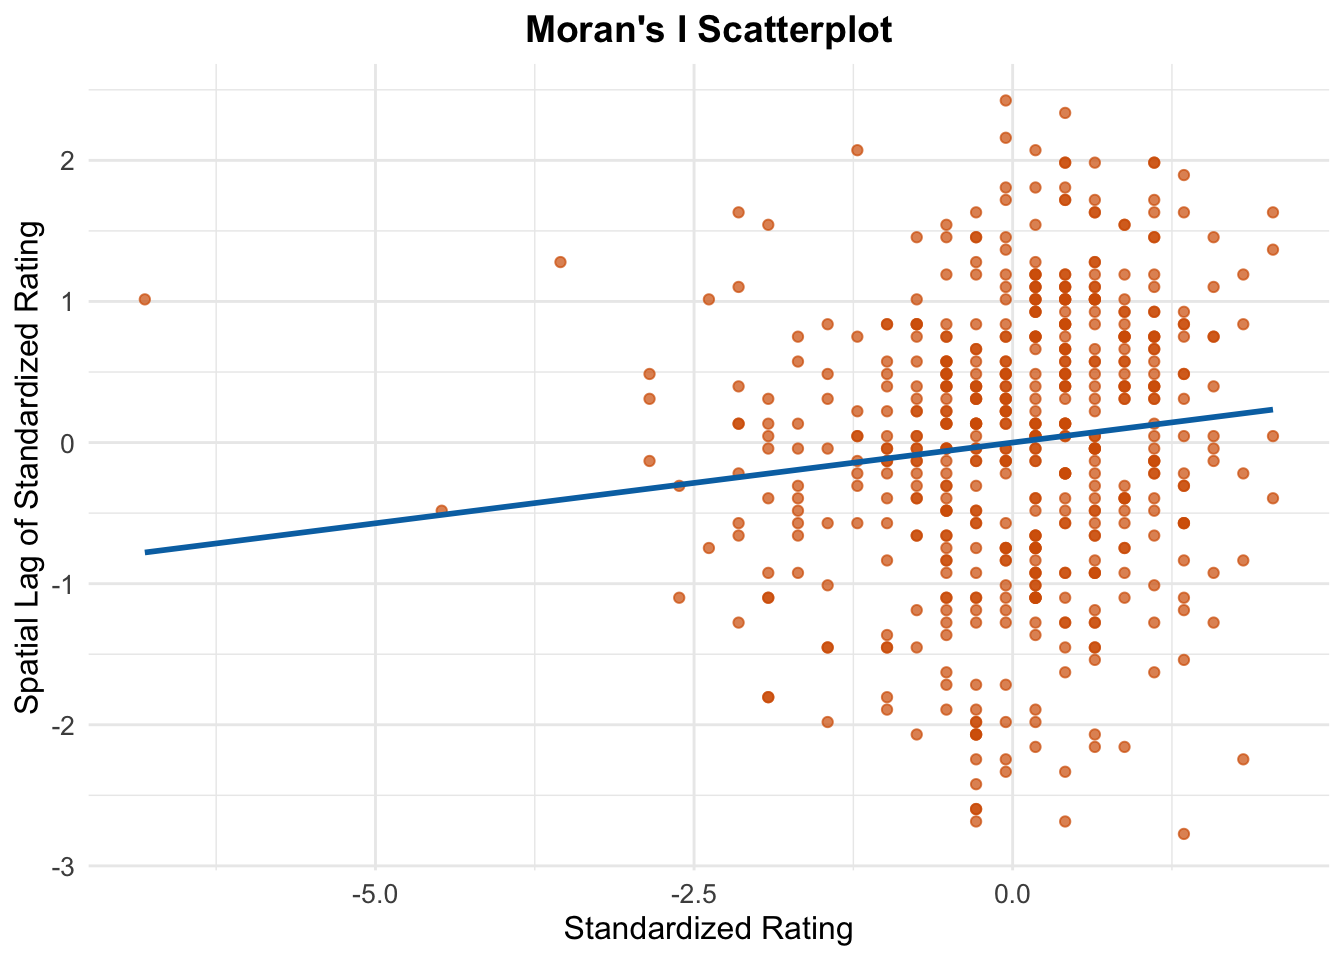

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
moran_lag <- lag.listw(listw_k, restaurant_sf$rating)

moran_data <- data.frame(
  rating = restaurant_sf$rating,                    
  spatial_lag = moran_lag                           
)


moran_data <- moran_data %>%
  mutate(
    rating_std = scale(rating, center = TRUE, scale = TRUE),      
    spatial_lag_std = scale(spatial_lag, center = TRUE, scale = TRUE) 
  )


moran_scatterplot <- ggplot(moran_data, aes(x = rating_std, y = spatial_lag_std)) +
  geom_point(color = "#D55E00", alpha = 0.7) +              
  geom_smooth(method = "lm", color = "#0072B2", se = FALSE) + 
  labs(
    title = "Moran's I Scatterplot",
    x = "Standardized Rating",
    y = "Spatial Lag of Standardized Rating"
  ) +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, size = 14, face = "bold"),  
    axis.title = element_text(size = 12),  
    axis.text = element_text(size = 10)   
  )

print(moran_scatterplot)

------------------------------------------------------------------------

### 4.3 Spacial Regression (SAR)

The spacial autocorrelation is significant and the residual autorrelation is not significant, which explains the spacial correlation. But we still try to include an additional spatial regression (SAR).

In [ ]:
#| code-fold: true
#| message: false
#| warning: false
sem_model <- lagsarlm(rating ~ AsianDensity , 
                        data = restaurant_sf, 
                        listw = listw_k)
summary(sem_model)


Call:lagsarlm(formula = rating ~ AsianDensity, data = restaurant_sf, 
    listw = listw_k)

Residuals:
      Min        1Q    Median        3Q       Max 
-2.923506 -0.207462  0.043672  0.284154  0.897993 

Type: lag 
Coefficients: (asymptotic standard errors) 
             Estimate Std. Error z value Pr(>|z|)
(Intercept)   3.45152    0.27237 12.6723  < 2e-16
AsianDensity  0.33504    0.16014  2.0921  0.03643

Rho: 0.1133, LR test value: 2.8326, p-value: 0.092369
Asymptotic standard error: 0.069451
    z-value: 1.6314, p-value: 0.1028
Wald statistic: 2.6615, p-value: 0.1028

Log likelihood: -292.659 for lag model
ML residual variance (sigma squared): 0.1805, (sigma: 0.42485)
Number of observations: 519 
Number of parameters estimated: 4 
AIC: 593.32, (AIC for lm: 594.15)
LM test for residual autocorrelation
test value: 9.2413, p-value: 0.0023662

The spatial regression shows that Asian population density indeed significantly impacts restaurant ratings. In addition, the spatial lag coefficient (Rho) is 0.1133 (p = 0.092). It only shows a limited spacial independence.

------------------------------------------------------------------------

## 5. Discussion

### 5.1 Main Findings

Our result shows that the higher Asian population density positively affects Chinese restaurant ratings. Also, high-rated Chinese restaurants exhibit spatial clustering. However, the spatial clustering of high-rated restaurants does not create spillover effects on nearby establishments.

------------------------------------------------------------------------

### 5.2 Interpretation of Result

#### 5.2.1 Support for Hotelling’s Model

In the DMV area, the data suggests some level of clustering. High-rated Chinese restaurants tend to appear near others, aligning partially with Hotelling’s idea of businesses grouping to share the market demand efficiently.

However, our finding of no significant spatial spillover effects indicates that the new restaurant’s presence doesn’t detract from the ratings of the existing restaurant. This suggests sufficient demand in the market for both restaurants, supporting Hotelling’s idea that businesses can coexist and compete successfully in proximity.

#### 5.2.2 Departure from Salop’s Model

Our findings don’t align strongly with Salop’s model because clustering occurs rather than spacing out. And the lack of a strong spillover effect from proximity further challenges Salop’s prediction.

#### 5.2.3 A Potential Third Framework

The lack of negative spillover effects and the persistence of clustering may indicate a “sufficient demand” scenario. In this case, clustering is sustainable because the density of demand (in areas with higher Asian populations) can support multiple businesses. This finding could contrast with markets like Flushing, NY, where high demand might already be saturated, and adding a new business could lead to a redistribution of customers or a drop in ratings.

------------------------------------------------------------------------

### 5.3 Limitation and Future Directions

Our dataset only contains Maryland residents, and it can be more interesting to investigate whether the no spillover effect holds in other regions, such as the Bay Area or Flushing, where the Asian population density is much higher. Besides, it can be analyzed how this pattern changes with varying levels of restaurant quality, as lower-rated restaurants may face stronger competition effects than higher-rated ones.

------------------------------------------------------------------------

## 6. Conclusion

Our evidence finds that Asian density significantly and positively affects Chinese restaurant ratings.